In [7]:
import numpy as np 
import matplotlib.pyplot as plt 

import os, cv2 
from PIL import Image
import random 
from natsort import natsorted 


from sklearn.model_selection import train_test_split
from skimage.restoration import inpaint

from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import load_model 

2023-11-13 14:23:18.829583: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 14:23:18.861532: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 14:23:18.962579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 14:23:18.962610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 14:23:18.962630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# DataSet Loading and Preprocessing

In [12]:
# train image, mask image path 
train_image_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/train/image"
train_mask_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/train/mask"  

# declare image size and list for image and mask 
img_size = 256 
train_image_dataset = [] 
train_mask_dataset = [] 

# list of image and mask 
list_of_images = os.listdir(train_image_path) 
list_of_images = natsorted(list_of_images)  
list_of_masks = os.listdir(train_mask_path)    
list_of_masks = natsorted(list_of_masks) 


# image reading and preprocessing 
for i, image_name in enumerate(list_of_images):
    image = cv2.imread(os.path.join(train_image_path, image_name), cv2.IMREAD_GRAYSCALE)
    image = Image.fromarray(image)
    image = image.resize((img_size, img_size)) 
    train_image_dataset.append(np.array(image))

# mask image reading and preprocessing 
for i, mask_name in enumerate(list_of_masks): 
    image_mask = cv2.imread(os.path.join(train_mask_path, mask_name), cv2.IMREAD_GRAYSCALE)
    image_mask = Image.fromarray(image_mask)
    image_mask = image_mask.resize((img_size, img_size)) 
    train_mask_dataset.append(np.array(image_mask)) 

In [13]:
print(len(train_image_dataset))

print(len(train_mask_dataset))

45
45


# Feature Engineering

In [14]:
# Normalizing images and rescale mask 0 to 1 
image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1), 3)
# rescale mask 0 to 1
mask_dataset = np.expand_dims((np.array(train_mask_dataset)), 3) / 255 


# Checking the shape of image_dataset and mask_dataset 
print("Shape of image_dataset is: ", image_dataset.shape) 
print("Shape of mask_dataset is: ", mask_dataset.shape)  

Shape of image_dataset is:  (45, 256, 256, 1)
Shape of mask_dataset is:  (45, 256, 256, 1)


# Dividing Dataset into train test

In [15]:
train_x, val_x, train_y, val_y = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0) 

# Visualize Some Data

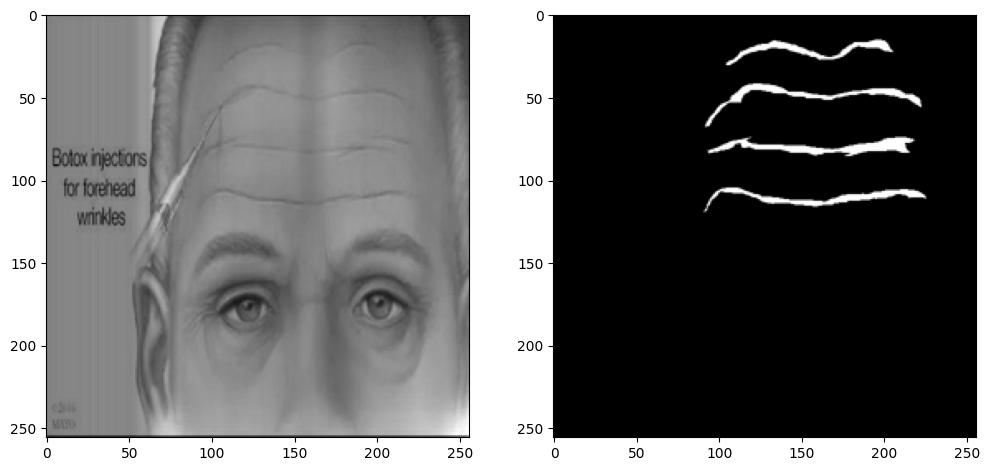

In [17]:
select_image_number = random.randint(0, len(train_x))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_x[select_image_number], (256, 256)), cmap='gray') 

plt.subplot(122)
plt.imshow(np.reshape(train_y[select_image_number], (256, 256)), cmap='gray') 
plt.show() 

# Image's Height, Width, Channel

In [18]:
# height, width, channel of image 
height = image_dataset.shape[1]
width = image_dataset.shape[2]
channel = image_dataset.shape[3]
print("Height of the image is: ", height) 
print("Width of the image is: ", width) 
print("Channel of the image is: ", channel)  

# height, width, channel of mask image 
mask_height = mask_dataset.shape[1]
mask_width = mask_dataset.shape[2]
mask_channel = mask_dataset.shape[3]
print("Height of the mask is: ", mask_height) 
print("Width of the mask is: ", mask_width) 
print("Channel of the mask is: ", mask_channel)  

Height of the image is:  256
Width of the image is:  256
Channel of the image is:  1
Height of the mask is:  256
Width of the mask is:  256
Channel of the mask is:  1


# Creating Deep Learning Model

In [19]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model 
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9) 
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model



model = simple_unet_model(height, width, channel) 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

# Training the Model

In [20]:
history = model.fit(train_x, train_y, batch_size=4, verbose=1, epochs=100, validation_data=(val_x, val_y), shuffle=False) 

Epoch 1/100
10/10 [==============================] - 8s 506ms/step - loss: 0.3180 - accuracy: 0.9374 - val_loss: 0.1869 - val_accuracy: 0.9598
Epoch 2/100
10/10 [==============================] - 5s 452ms/step - loss: 0.1652 - accuracy: 0.9637 - val_loss: 0.1755 - val_accuracy: 0.9598
Epoch 3/100
10/10 [==============================] - 4s 445ms/step - loss: 0.1360 - accuracy: 0.9637 - val_loss: 0.1514 - val_accuracy: 0.9598
Epoch 4/100
10/10 [==============================] - 4s 443ms/step - loss: 0.1130 - accuracy: 0.9637 - val_loss: 0.1246 - val_accuracy: 0.9598
Epoch 5/100
10/10 [==============================] - 4s 442ms/step - loss: 0.1060 - accuracy: 0.9637 - val_loss: 0.1219 - val_accuracy: 0.9598
Epoch 6/100
10/10 [==============================] - 4s 443ms/step - loss: 0.1031 - accuracy: 0.9637 - val_loss: 0.1057 - val_accuracy: 0.9598
Epoch 7/100
10/10 [==============================] - 4s 449ms/step - loss: 0.0995 - accuracy: 0.9637 - val_loss: 0.1062 - val_accuracy: 0.9598

# Train and Validation Accuracy and Loss

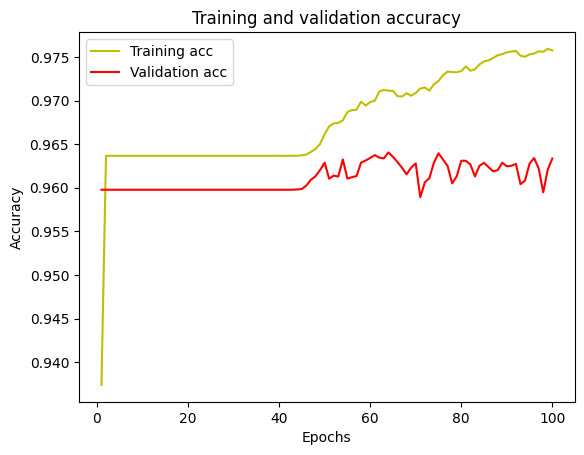

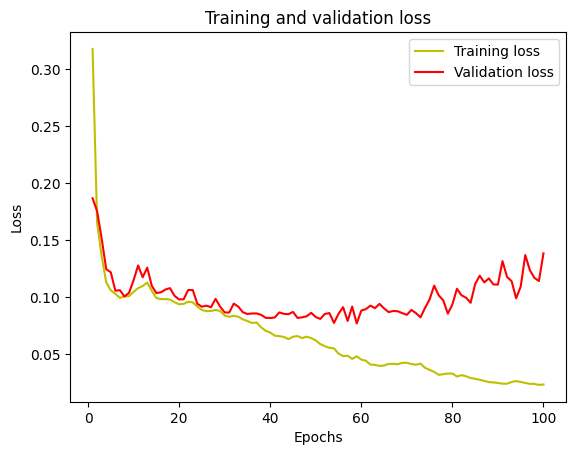

In [21]:
# Training and Validation accuracy graph 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Training and Validation loss graph
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate with Test dataset 

In [5]:
def test_and_mask_image_prepared(test_img_path, test_mask_path):    
    # test image, mask image path 
    test_image_path = test_img_path
    test_mask_path = test_mask_path 

    # declare image size and list for image and mask 
    img_size = 256
    test_image_dataset = []
    test_mask_dataset = [] 

    # list of image and mask 
    test_list_of_images = os.listdir(test_img_path)
    test_list_of_images = natsorted(test_list_of_images) 
    test_list_of_masks = os.listdir(test_mask_path)   
    test_list_of_masks = natsorted(test_list_of_masks) 

    # image reading and preprocessing 
    for i, image_name in enumerate(test_list_of_images):
        image = cv2.imread(os.path.join(test_image_path, image_name), cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image) 
        image = image.resize((img_size, img_size)) 
        test_image_dataset.append(np.array(image))

    # mask image reading and preprocessing 
    for i, mask_name in enumerate(test_list_of_masks):  
        image_mask = cv2.imread(os.path.join(test_mask_path, mask_name), cv2.IMREAD_GRAYSCALE)
        image_mask = Image.fromarray(image_mask)
        image_mask = image_mask.resize((img_size, img_size)) 
        test_mask_dataset.append(np.array(image_mask)) 


    # Normalizing images and rescale mask 0 to 1 
    test_image_dataset_processed = np.expand_dims(normalize(np.array(test_image_dataset), axis=1), 3)
    # rescale mask 0 to 1
    test_mask_dataset_processed = np.expand_dims((np.array(test_mask_dataset)), 3) / 255 


    # Checking the shape of image_dataset and mask_dataset 
    print("Shape of image_dataset is: ", test_image_dataset_processed.shape) 
    print("Shape of mask_dataset is: ", test_mask_dataset_processed.shape)  

    return test_image_dataset_processed, test_mask_dataset_processed 


# path of the test image and mask 
test_img_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/image" 
test_mask_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/mask" 
# calling function for test data preprocessing 
test_img_processed, test_mask_processed = test_and_mask_image_prepared(test_img_path, test_mask_path)  

# model evaluation 
loss, acc = loaded_model_pretrained.evaluate(test_img_processed, test_mask_processed)
print("loss = ",loss)
print("Accuracy = ", (acc * 100.0), "%") 

Shape of image_dataset is:  (5, 256, 256, 1)
Shape of mask_dataset is:  (5, 256, 256, 1)
1/1 [==============================] - 1s 751ms/step - loss: 0.0474 - accuracy: 0.9873
loss =  0.047437578439712524
Accuracy =  98.7286388874054 %


# Save the Model

In [4]:
# Model Saving 
#model.save("/home/hasanmoni123/SoftNursery/Face_Tune/model/unet_mask.h5") 

# Model loading 
loaded_model_pretrained = load_model('/home/hasanmoni123/SoftNursery/Face_Tune/model/unet_mask.h5') 

# Finding IoU Score of Test Dataset

In [6]:
y_pred = loaded_model_pretrained.predict(test_img_processed)
threshold = y_pred > 0.5

intersection = np.logical_and(test_mask_processed, threshold) 
union = np.logical_or(test_img_processed, threshold) 
iou_score = np.sum(intersection) / np.sum(union) 
print("IoU score is: ", iou_score) 

1/1 [==============================] - 0s 488ms/step
IoU score is:  0.003989475616471884


# Testing with a single new image

In [7]:
# Finding IoU Scores 
img_number = random.randint(0, (len(test_img_processed)-1))
image = test_img_processed[img_number] 
mask = test_mask_processed[img_number] 

image_norm = image[:,:,0][:,:,None] 
image_norm_input = np.expand_dims(image_norm, 0)   
prediction = (loaded_model_pretrained.predict(image_norm_input)[0,:,:0] > 0.2).astype(np.uint8) 

1/1 [==============================] - 0s 85ms/step


In [8]:
image_new = cv2.imread("/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/image/w_14.jpg", cv2.IMREAD_GRAYSCALE) 
image_new =  cv2.resize(image_new, (256, 256)) 
image_new_norm = np.expand_dims(normalize(np.array(image_new), axis=1), 2) 
image_new_norm_shape = image_new_norm[:,:,0][:,:,None] 
image_new_norm_shape_input = np.expand_dims(image_new_norm_shape, axis=0) 
print("Shape of image_new_norm_shape_input is: ", image_new_norm_shape_input.shape) 

Shape of image_new_norm_shape_input is:  (1, 256, 256, 1)


1/1 [==============================] - 0s 81ms/step


/tmp/ipykernel_19535/2152439737.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(prediction, cmap='gray')


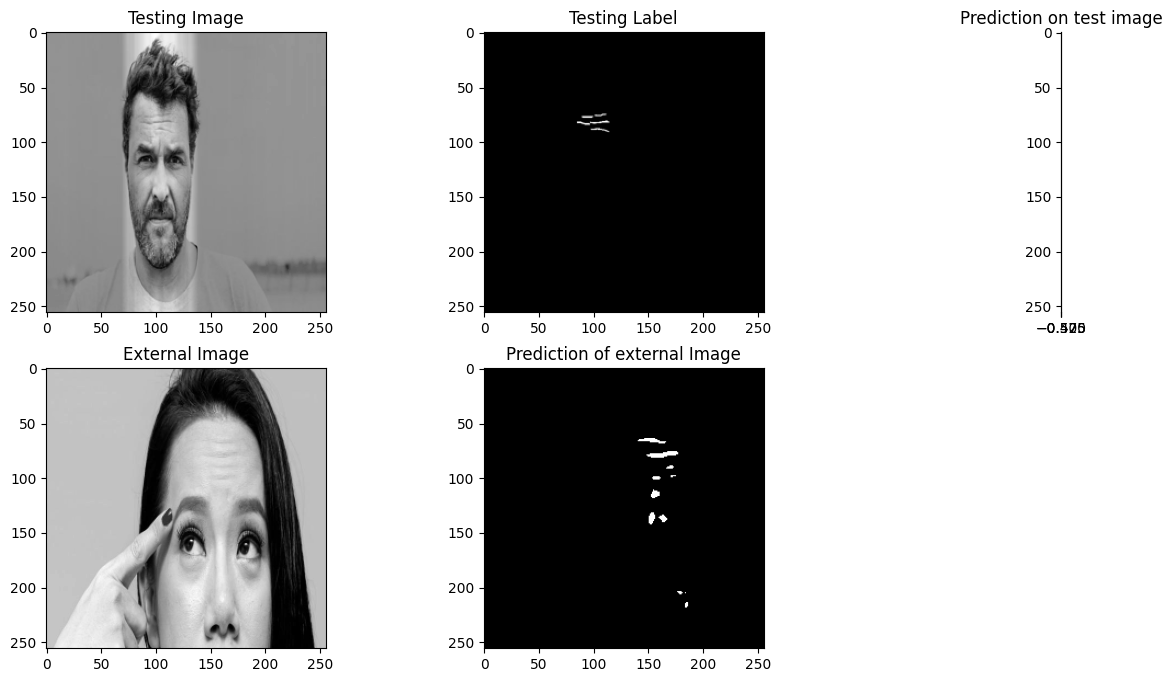

In [9]:
prediction_new_image_mask = (loaded_model_pretrained.predict(image_new_norm_shape_input)[0,:,:,0] > 0.2).astype(np.uint8) 


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image[:,:,0], cmap='gray')
plt.subplot(232)

plt.title('Testing Label')
plt.imshow(mask[:,:,0], cmap='gray')
plt.subplot(233)

plt.title('Prediction on test image') 
plt.imshow(prediction, cmap='gray') 
plt.subplot(234)

plt.title('External Image')
plt.imshow(image_new, cmap='gray')
plt.subplot(235)

plt.title('Prediction of external Image')
plt.imshow(prediction_new_image_mask, cmap='gray')
plt.show() 

In [10]:
prediction_new_image_mask.save("./w_14_mask.jpg")

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [11]:
cv2.imwrite("./w_14_mask.jpg", prediction_new_image_mask) 

True

In [14]:
plt.imsave("./w_14_mask_2.jpg", prediction_new_image_mask)  

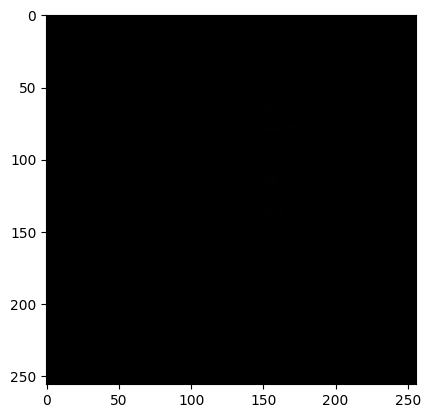

In [12]:
a = cv2.imread("./w_14_mask.jpg")
plt.imshow(a, cmap='gray')
plt.show() 

In [13]:
a.shape

(256, 256, 3)

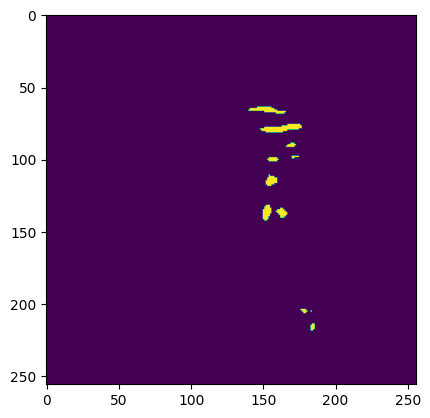

In [17]:
plt.imshow(prediction_new_image_mask)
plt.show()

In [12]:
prediction_new_image_mask.shape 

(256, 256)

In [13]:
prediction_new_image_mask 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
import matplotlib.pyplot as plt
import PIL
import requests
from io import BytesIO

from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, StableDiffusionInpaintPipeline
import torch

In [20]:
model_id = "stabilityai/stable-diffusion-2-base"

def preprocessed_image(url_path):
  img_prepro = PIL.Image.open(url_path).convert("RGB").resize((256, 256))
  return img_prepro


def wrinkle_remove_using_stable_diffusion_2_inpaint(img_url, mask_url, streng, num_inferen):

  img = preprocessed_image(img_url)
  mask = preprocessed_image(mask_url) 


  pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
  )
  pipe = pipe.to("cuda")

  prompt = ""
  inpaint = pipe(prompt=prompt, image=img, mask_image=mask, strength=streng, num_inference_steps=num_inferen).images[0]



  fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 12))
  ax = axes.ravel()

  ax[0].set_title('Original image')
  ax[0].imshow(img)

  ax[1].set_title('Mask')
  ax[1].imshow(mask, cmap=plt.cm.gray)

  ax[2].set_title('Inpainted image')
  ax[2].imshow(inpaint)

  for a in ax:
    a.axis('off')

  fig.tight_layout()
  plt.show()

  return img, inpaint

img_path = "/home/hasanmoni123/SoftNursery/Face_Tune/100_forehead_wrinkle_images_resized/w_14.jpg"
mask_path = "/home/hasanmoni123/SoftNursery/Face_Tune/w_14_mask_2.jpg" 
streng = 1.0 
num_inferen = 200
orig_image, inpaint_image = wrinkle_remove_using_stable_diffusion_2_inpaint(img_path, mask_path, streng, num_inferen)


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]















































































































































































































Fetching 13 files:  31%|███       | 4/13 [12:06<27:14, 181.58s/it]





In [29]:
b = Image.fromarray(prediction_new_image_mask) 
c = b.convert('RGB').resize((256, 256)) 

In [ ]:
import pickle, os, cv2, PIL 
import numpy as np 
#from crypt import methods
import matplotlib.pyplot as plt 
import requests
#from io import BytesIO

from tensorflow.keras.utils import normalize
from keras.models import load_model 
#from diffusers import StableDiffusionInpaintPipeline
#import torch

from flask import Flask, render_template, request


app = Flask(__name__) 


# Model loading 
loaded_model_pretrained = load_model('./models/unet_mask.h5') 


def mask_image_creation(img_path): 
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    image_resize = cv2.resize(image, (256, 256)) 
    image_normalize = np.expand_dims(normalize(np.array(image_resize), axis=1), 2) 
    image_gray = image_normalize[:,:,0][:,:,None] 
    image_expand = np.expand_dims(image_gray, axis=0) 
    # prediction with the model 
    predicted_mask = (loaded_model_pretrained.predict(image_expand)[0,:,:,0] > 0.2).astype(np.uint8) 
    return predicted_mask


def preprocessed_image(url_path):
  img_prepro = PIL.Image.open(url_path).convert("RGB").resize((256, 256))
  return img_prepro


def wrinkle_remove_using_stable_diffusion_2_inpaint(img_url, mask_url, streng, num_inferen):
    
    img = preprocessed_image(img_url)
    mask = preprocessed_image(mask_url)
 

    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
    )
    pipe = pipe.to("cuda")

    prompt = ""
    inpaint = pipe(prompt=prompt, image=img, mask_image=mask, strength=streng, num_inference_steps=num_inferen).images[0]
    return inpaint




# routes
@app.route("/", methods=['GET', 'POST'])
def main():
    return render_template("index.html")


@app.route("/about")
def about_page():
    return "Please Check the prediction..!!!"


@app.route("/submit", methods = ['GET', 'POST'])
def get_output():
    if request.method == 'POST':
        img = request.files['my_image']

        img_path = "orig_img/" + img.filename	
        img.save(img_path) 

        #p = predict_label(img_path) 
        predicted_mask_img = mask_image_creation(img_path) 

        # generating name of the image 
        mask_path = "mask_img/" + img.filename	 
        # saving the mask image 
        plt.imsave(mask_path, predicted_mask_img) 

        # inpainting 
        # img_path = img_path 
        # mask_path = mask_path 
        #strength = request.form['strength'] 
        #num_inference_steps = request.form['num_inference_steps'] 
        #inpainted_image = wrinkle_remove_using_stable_diffusion_2_inpaint(img_path, mask_path, strength, num_inference_steps)
        #inpainted_path = "inpainted_img/" + img.filename
        #plt.imsave(inpainted_path, inpainted_image) 

    return render_template("index.html", prediction = "Wrinkle Removed", orig_img = img_path, mask_img = img_path)   


if __name__ =='__main__':
    #app.debug = True
    app.run(debug = True) 

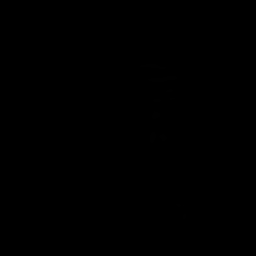

In [31]:
   <div> 
        <label style="color: darkolivegreen" for="strength">Strength(between 0.1 to 1)</label> 
        <input type="number" id="strength" name="strength"  required> 
        <br> 
        <br>

        <label style="color: darkolivegreen" for="num_inference_steps"> Number of Inference Steps(between 1 to 250)</label> 
        <input type="number" id="num_inference_steps" name="num_inference_steps" required>
        <br> 
        <br> 
    </div>

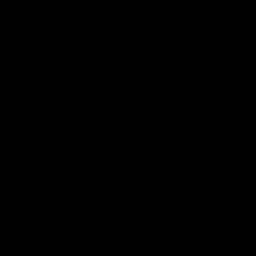

In [33]:
k = Image.fromarray(prediction_new_image_mask)
k

In [35]:
prediction_new_image_mask.shape 

(256, 256)

In [37]:
type(prediction_new_image_mask)

numpy.ndarray

In [10]:
# deleting previous data/image
import os 

path = "./extra/"

all_file = os.listdir(path)
for f in all_file:
    os.unlink(os.path.join(path, f))  



In [11]:
all_file

['w_14_mask_2.jpg', 'w_14_mask.jpg']

# Process No. 1
### Removing Wrinkles using Inpainting of Scikit-Image

1/1 [==============================] - 0s 31ms/step


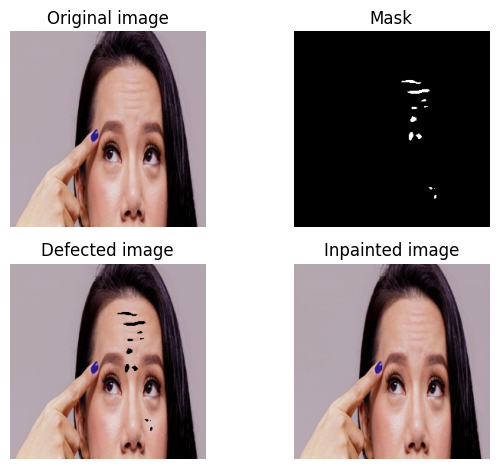

In [32]:
def predict_a_single_new_image(img_path): 
    # Reading original image 
    img = Image.open(img_path)
    img = img.resize((256, 256))  
    img_arr = np.asarray(img) 
    # Reading Grayscale image 
    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    orig_img_resized =  cv2.resize(orig_img, (256, 256)) 
    orig_img_expand = np.expand_dims(normalize(np.array(orig_img_resized), axis=1), 2) 
    orig_img_shape = orig_img_expand[:,:,0][:,:,None] 
    orig_img_processed = np.expand_dims(orig_img_shape, axis=0) 

    # prediction with AI model 
    prediction_mask_img = (loaded_model_pretrained.predict(orig_img_processed)[0,:,:,0] > 0.2).astype(np.uint8) 
    prediction_mask_img = np.array(prediction_mask_img, dtype=bool) 

    # Creating defected image 
    image_defect = img_arr * ~prediction_mask_img[..., np.newaxis]

    # Inpainting 
    image_result = inpaint.inpaint_biharmonic(image_defect, prediction_mask_img, channel_axis=-1)


    #plt.figure(figsize=(16, 8))
    fig, axes = plt.subplots(ncols=2, nrows=2)
    ax = axes.ravel()

    ax[0].set_title('Original image')
    ax[0].imshow(img)

    ax[1].set_title('Mask')
    ax[1].imshow(prediction_mask_img, cmap=plt.cm.gray)

    ax[2].set_title('Defected image')
    ax[2].imshow(image_defect)

    ax[3].set_title('Inpainted image')
    ax[3].imshow(image_result)

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    return img, prediction_mask_img, image_defect, image_result 


img_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/image/w_14.jpg" 
img, predicted_mask_img, image_defected, image_result = predict_a_single_new_image(img_path) 
 

# Process No. 2
### Removing Wrinkles using Inpainting of CV2

1/1 [==============================] - 0s 34ms/step


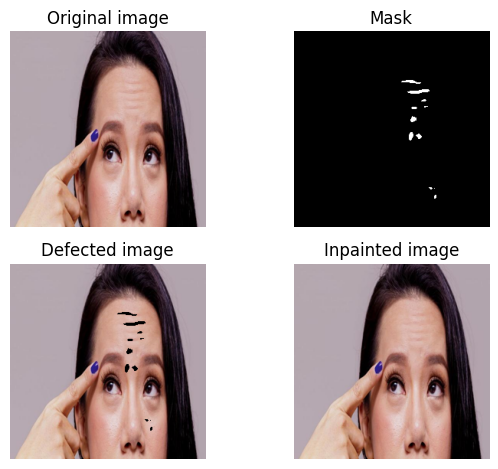

In [33]:
def remove_wrinkle_cv2_inpaint_ns(img_path):  
    img = Image.open(img_path)
    img = img.resize((256, 256))  
    img_arr = np.asarray(img) 
    
    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    orig_img_resized =  cv2.resize(orig_img, (256, 256)) 
    orig_img_expand = np.expand_dims(normalize(np.array(orig_img_resized), axis=1), 2) 
    orig_img_shape = orig_img_expand[:,:,0][:,:,None] 
    orig_img_processed = np.expand_dims(orig_img_shape, axis=0)

    # prediction with AI model 
    prediction_mask_img = (loaded_model_pretrained.predict(orig_img_processed)[0,:,:,0] > 0.2).astype(np.uint8) 
    prediction_mask_img_bool = np.array(prediction_mask_img, dtype=bool) 

    # Creating defected image 
    image_defect = img_arr * ~prediction_mask_img_bool[..., np.newaxis] 

    # Inpainting 
    inpaint_output = cv2.inpaint(image_defect, prediction_mask_img, 3, cv2.INPAINT_NS) 
    
    #

    fig, axes = plt.subplots(ncols=2, nrows=2)
    ax = axes.ravel()

    ax[0].set_title('Original image')
    ax[0].imshow(img_arr)

    ax[1].set_title('Mask')
    ax[1].imshow(prediction_mask_img, cmap=plt.cm.gray)

    ax[2].set_title('Defected image')
    ax[2].imshow(image_defect)

    ax[3].set_title('Inpainted image')
    ax[3].imshow(inpaint_output)

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    return img_arr, prediction_mask_img, prediction_mask_img_bool, image_defect, inpaint_output 
    

img_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/image/w_14.jpg"
img_arr, prediction_mask_img, prediction_mask_img_bool, image_defect, inpainted_output = remove_wrinkle_cv2_inpaint_ns(img_path)  

1/1 [==============================] - 0s 35ms/step


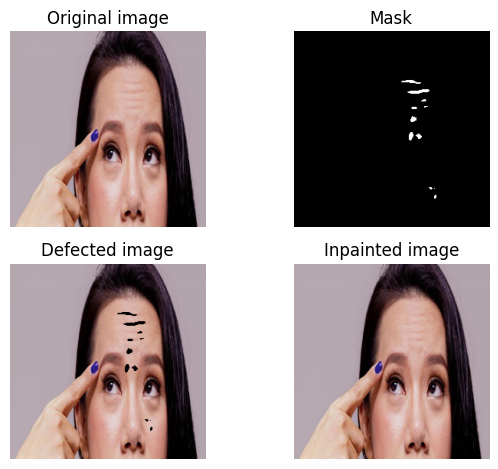

In [34]:
def remove_wrinkle_cv2_inpaint_telea(img_path):  
    img = Image.open(img_path)
    img = img.resize((256, 256))  
    img_arr = np.asarray(img) 
    
    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    orig_img_resized =  cv2.resize(orig_img, (256, 256)) 
    orig_img_expand = np.expand_dims(normalize(np.array(orig_img_resized), axis=1), 2) 
    orig_img_shape = orig_img_expand[:,:,0][:,:,None] 
    orig_img_processed = np.expand_dims(orig_img_shape, axis=0)

    # prediction with AI model 
    prediction_mask_img = (loaded_model_pretrained.predict(orig_img_processed)[0,:,:,0] > 0.2).astype(np.uint8) 
    prediction_mask_img_bool = np.array(prediction_mask_img, dtype=bool) 

    # Creating defected image 
    image_defect = img_arr * ~prediction_mask_img_bool[..., np.newaxis] 

    # Inpainting 
    inpaint_output = cv2.inpaint(image_defect, prediction_mask_img, 3, cv2.INPAINT_TELEA)  
    
     

    fig, axes = plt.subplots(ncols=2, nrows=2)
    ax = axes.ravel()

    ax[0].set_title('Original image')
    ax[0].imshow(img_arr)

    ax[1].set_title('Mask')
    ax[1].imshow(prediction_mask_img, cmap=plt.cm.gray)

    ax[2].set_title('Defected image')
    ax[2].imshow(image_defect)

    ax[3].set_title('Inpainted image')
    ax[3].imshow(inpaint_output)

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    # return all the images 
    return img_arr, prediction_mask_img, prediction_mask_img_bool, image_defect, inpaint_output
    

img_path = "/home/hasanmoni123/SoftNursery/Face_Tune/dataset/test/image/w_14.jpg"
img_arr, prediction_mask_img, prediction_mask_img_bool, image_defect, inpainted_output = remove_wrinkle_cv2_inpaint_telea(img_path) 
  